In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

### Cargamos el dataset

In [68]:
df = pd.read_csv('titanic.csv')

In [69]:
df['Pclass'] = df.Pclass.astype(object)

Eliminamos las columnas que no son predicturas

In [70]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

Creamos cageogoricas

In [71]:
df = pd.get_dummies(df, drop_first=True)

In [72]:
df['Age'] = df['Age'].fillna(df.Age.mean())


### Crea una regresion logistica

In [73]:
target= 'Survived'
X= df.drop(target, axis=1)
y= df[target]

model= linear_model.LogisticRegression().fit(X, y)
probabilities= model.predict_proba(X)

p1= [i[1] for i in probabilities]

### Concepto odds

Mi equipo gana 1 a 4


In [74]:
1/4

0.25

Probabilidad de ganar 

In [75]:
1/(1+4)

0.2

Probabilidad perder

In [76]:
1 - 1/(1+4)

0.8

Mi equipo gana 5 a 3

In [77]:
5/3

1.6666666666666667

Probabilidad que equipo gane 

In [78]:
5 / (5+3)

0.625

Probabilidd de perder

In [79]:
1-(5/(5+3))

0.375

¿Qué pasa si divido la probabilidad de ganar entre la probabiliad de perder?

In [80]:
p= (5/(5+3))

p/(1-p)

1.6666666666666667

$$odds = \frac{p}{1-p}$$

Calcula los odds de las predicciones del modelo

In [81]:
odds_titanic= [i / (1-i) for i in p1]


Los odds pueden llegar a ser muy volatiles, pon el histograma

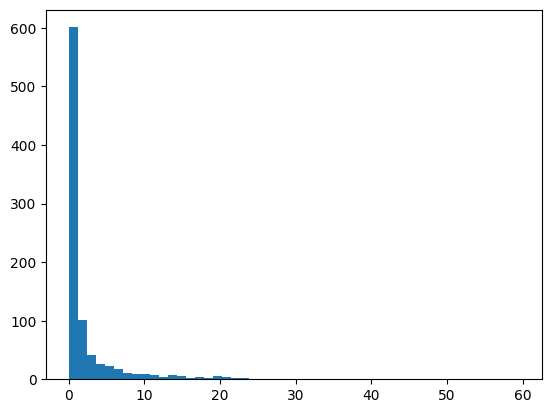

In [82]:
plt.hist(odds_titanic, bins=50)
plt.show()

$$log(odds) = log(\frac{p}{1-p})$$

Pero el log odds no es tan disperso, histograma del log odds

<function matplotlib.pyplot.show(close=None, block=None)>

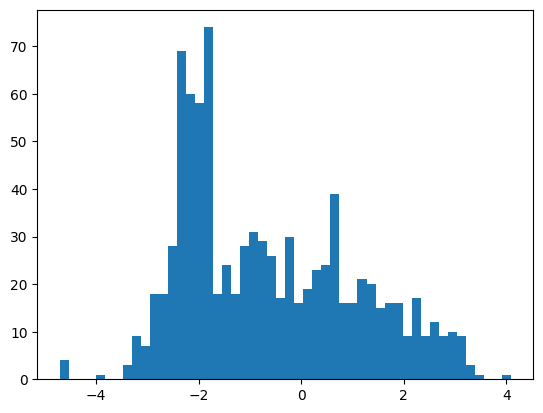

In [83]:
log_odds_titanic= np.log(odds_titanic)
plt.hist(log_odds_titanic, bins=50)
plt.show

### ¿Y esto que? 

Si tomamos los coeficientes de una regresión logistica como si gura una regresión lineal, obtenemos un numero extraño

$$z = \Theta ^T X $$



In [84]:
# Calcula Z
z= (model.coef_ * X).sum(axis=1) + model.intercept_

Resulta ser que z es lo mismo que log odds

In [85]:
verdad= pd.DataFrame({
    'z': z,
    'log_odds': log_odds_titanic
})
verdad

,z,log_odds
0,-2.289000,-2.289000
1,2.280929,2.280929
2,0.450379,0.450379
3,1.870247,1.870247
4,-2.455872,-2.455872
...,...,...
886,-0.961279,-0.961279
887,2.697958,2.697958
888,-0.102996,-0.102996
889,0.329303,0.329303


In [86]:
coeficientes = pd.DataFrame({
    'features': X.keys(),
    'coef': model.coef_[0]
})
coeficientes

,features,coef
0,Age,-0.036885
1,SibSp,-0.310117
2,Parch,-0.077792
3,Fare,0.003141
4,Pclass_2,-0.736078
5,Pclass_3,-1.920044
6,Sex_male,-2.574680
7,Embarked_Q,-0.071501
8,Embarked_S,-0.464219


### Esto es importante porque de aquí sale sigmoide

$$log(\frac{p}{1-p}) = \Theta ^T X$$


Aplicamos la exponencial en ambos lados:

$$
e^{\Theta ^T X} = \frac{p}{1 - p}
$$

Despejamos \( p \):

$$
p = \frac{e^{\Theta ^T X}}{1 + e^{\Theta ^T X}}
$$

Simplificando

$$
p= \frac{1}{1 + e^{\Theta ^T X}}
$$

Comprobando

### _Comprobamos que Sklearn opera conforme a la teoría_ 

### Comparando diferentes tipos de regresiones

#### Regresion logistica


In [87]:
target = 'Survived'

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model = linear_model.LogisticRegression().fit(X_train, y_train)
probabilities_modelo1= model.predict_proba(X_test)[:,1]   

#### Checando los coeficientes

In [89]:
## Checa los coeficientes, que significan?


  #### Regresion logistica polinomial 2


In [90]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


pipeline= Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2)),
    ("model", linear_model.LogisticRegression(penalty='l2'))
])
pipeline.fit(X_train, y_train)
probabilities_modelo2= pipeline.predict_proba(X_test)[:,1]


#### Polinomio grado 3

In [91]:
pipeline= Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=3)),
    ("model", linear_model.LogisticRegression(penalty='l2'))
])
pipeline.fit(X_train, y_train)
probabilities_modelo3= pipeline.predict_proba(X_test)[:,1]


#### Analisis del discriminante lineal 

In [92]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pipeline= Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearDiscriminantAnalysis())
])
pipeline.fit(X_train, y_train)
probabilidades_modelo_disc= pipeline.predict_proba(X_test)[:,1]


### Junta los datasets

In [93]:
juntar = pd.DataFrame({
    'real': y_test,
    'logistica1': probabilities_modelo1,
    'logistica2': probabilities_modelo2,
    'logistica3': probabilities_modelo3,
    'probabilidades_disc': probabilidades_modelo_disc
})
juntar.head()

,real,logistica1,logistica2,logistica3,probabilidades_disc
495,0,0.154929,0.186737,2.131809e-01,0.094228
648,0,0.104622,0.124614,1.369802e-01,0.056745
278,0,0.076536,0.011373,2.245703e-07,0.066734
31,1,0.933829,0.993344,9.999965e-01,0.971403
255,1,0.691419,0.647217,9.840555e-01,0.741915


In [94]:
# Bins
bins = 5
juntar['bins_log1']= pd.qcut(juntar.logistica1, bins, labels=False)+1
juntar['bins_log2']= pd.qcut(juntar.logistica2, bins, labels=False)+1
juntar['bins_log3']= pd.qcut(juntar.logistica1, bins, labels=False)+1
juntar['bins_disc']= pd.qcut(juntar.probabilidades_disc, bins, labels=False)+1

# Agrupaciones
grouped1= juntar.groupby(['bins_log1']).mean()
grouped2= juntar.groupby(['bins_log2']).mean()
grouped3= juntar.groupby(['bins_log3']).mean()
grouped_disc= juntar.groupby(['bins_disc']).mean()



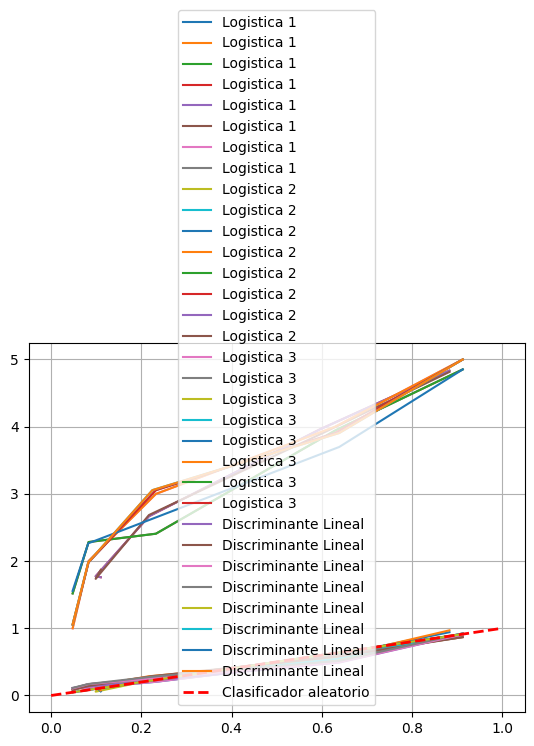

In [101]:
## Grafico de modelos
plt.plot(grouped1.probabilidades_disc, grouped1, label='Logistica 1')
plt.plot(grouped2.probabilidades_disc, grouped2, label='Logistica 2')
plt.plot(grouped3.probabilidades_disc, grouped3, label='Logistica 3')
plt.plot(grouped_disc.probabilidades_disc, grouped_disc, label='Discriminante Lineal')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.legend()
plt.grid()


¿Cuál es mejor? Veamos la función de perdida en el conjunto de prueba

$$
\text{LogLoss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
$$

In [96]:
from sklearn.metrics import log_loss

Modelo logistico

In [97]:
log_loss(y_pred= juntar.logistica1, y_true= juntar.real)


0.44386177543913546

Modelo polinomio 2

In [98]:
log_loss(y_pred= juntar.logistica2, y_true= juntar.real)


0.4350031665646779

Modelo polinomio 3

In [99]:
log_loss(y_pred= juntar.logistica3, y_true= juntar.real)


0.6811981410183374

Modelo discriminante

In [ ]:
log_loss(y_pred=calibracion.modelo_discriminante_lineal, y_true=calibracion.real)

AttributeError: module 'sklearn.calibration' has no attribute 'modelo_discriminante_lineal'

#### Histogramas

In [ ]:
real1 = calibracion.query("real == 1").logistica1, density=True, alpha=0.5
real0 = calibracion.query("real == 0").logistica1, density=True, alpha=0.5


SyntaxError: unmatched ')' (498584261.py, line 1)

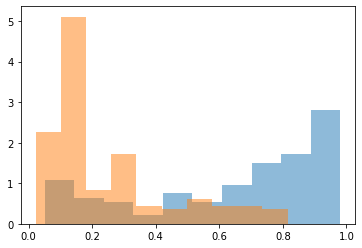

In [ ]:
plt.hist(real1.modelo_lineal, density=True, alpha=0.5, bins=10)
plt.hist(real0.modelo_lineal, density=True, alpha=0.5, bins=10)
plt.show()

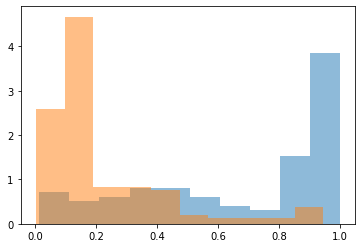

In [ ]:
plt.hist(real1.modelo_cuadratico, density=True, alpha=0.5, bins=10)
plt.hist(real0.modelo_cuadratico, density=True, alpha=0.5, bins=10)
plt.show()

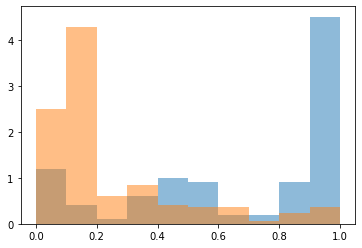

In [ ]:
plt.hist(real1.modelo_cubico, density=True, alpha=0.5, bins=10)
plt.hist(real0.modelo_cubico, density=True, alpha=0.5, bins=10)
plt.show()

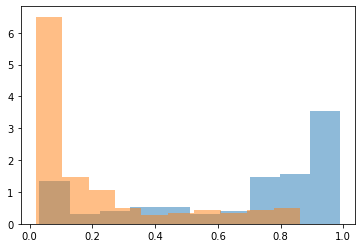

In [ ]:
plt.hist(real1.modelo_discriminante_lineal, density=True, alpha=0.5, bins=10)
plt.hist(real0.modelo_discriminante_lineal, density=True, alpha=0.5, bins=10)
plt.show()